In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
%matplotlib inline
# from matplotlib import pyplot as plt
# import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
import os

In [2]:
DATA_DIR = '../../data/'
http_bots = pq.read_table(os.path.join(DATA_DIR, 'botsHTTPRequests-20180216_1416GMT.parquet')).to_pandas()
http_users = pq.read_table(os.path.join(DATA_DIR, 'usersHTTPRequests-20180216_1416GMT.parquet')).to_pandas()
http_users['target'] = 0
http_bots['target'] = 1
http = pd.concat([http_bots, http_users])
http = http.sample(frac=1).reset_index(drop=True)
http.shape

(1010377, 14)

# Поисследуем признаки

In [3]:
import seaborn as sns

In [4]:
#http.drop('hour', axis=1, inplace=True)
http.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010377 entries, 0 to 1010376
Data columns (total 14 columns):
browserId      1010071 non-null float64
from           31871 non-null object
ip             1010377 non-null object
method         1002598 non-null object
operation      1010339 non-null object
referrer       993440 non-null object
requestType    1010377 non-null object
timestamp      1010377 non-null int64
to             60926 non-null object
url            1010377 non-null object
userAgent      1010372 non-null object
userId         1010377 non-null object
hour           1010377 non-null int32
target         1010377 non-null int64
dtypes: float64(1), int32(1), int64(2), object(10)
memory usage: 104.1+ MB


In [5]:
http.describe(include=['object'])

,from,ip,method,operation,referrer,requestType,to,url,userAgent,userId
count,31871,1010377,1002598,1010339,993440,1010377,60926,1010377,1010372,1010377
unique,99,481794,3,479,15072,4,117,71141,11100,678920
top,userMain,3rRnET9ABG3feVMANINXpg==,POST,SuggestStickers,https://ok.ru/,REQ,userMain,https://ok.ru/dk,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...,0hs35/dB/t+uT7u/c71+Vw==
freq,11503,3288,923838,139416,874116,941672,17926,573978,56852,1556


### Посмотрим на признаки поотдельности

In [6]:
http['method'].value_counts()

POST    923838
GET      78751
HEAD         9
Name: method, dtype: int64

In [7]:
pd.crosstab(http['target'], http['method'], normalize=True)

method,GET,HEAD,POST
target,,,
0,0.074885,0.000009,0.914755
1,0.003661,0.000000,0.006689


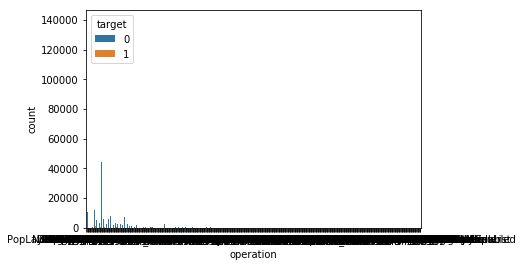

In [8]:
sns.countplot(x='operation', hue='target', data=http)

In [9]:
http['referrer'].value_counts().head()

https://ok.ru/                                            874116
https://www.ok.ru/                                         92836
https://ok.ru                                               2775
https://st.mycdn.me/static/MegaPlayer/10-8-31/vp11.swf      2635
https://ok.ru/feed                                           544
Name: referrer, dtype: int64

In [10]:
http['requestType'].value_counts()

REQ        941672
NAV         60926
CSP          7741
UPGRADE        38
Name: requestType, dtype: int64

In [11]:
pd.crosstab(http['target'], http['requestType'], normalize=True)

requestType,CSP,NAV,REQ,UPGRADE
target,,,,
0,0.007661,0.058191,0.923839,0.000038
1,0.000000,0.002109,0.008161,0.000000


### Почистим данные

In [3]:
http.drop(['browserId', 'from', 'ip',
           'referrer', 'timestamp',
           'to', 'userId', 'hour'],  axis=1, inplace=True)

http.head()

,method,operation,requestType,url,userAgent,target
0,POST,appTouch,REQ,https://ok.ru/dk,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,0
1,POST,DiscussionsUnsubscribe,REQ,https://ok.ru/dk,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,0
2,POST,PopLayerPhoto,REQ,https://www.ok.ru/diana...ficajmalety,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
3,GET,spring-mvc,REQ,https://ok.ru/web-api/pts/discussion.client,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,0
4,POST,FriendFeedsMRB,REQ,https://ok.ru/valentina.pravdzivayagol,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,0


In [4]:
http.describe(include=['object'])

,method,operation,requestType,url,userAgent
count,1002598,1010339,1010377,1010377,1010372
unique,3,479,4,71141,11100
top,POST,SuggestStickers,REQ,https://ok.ru/dk,Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...
freq,923838,139416,941672,573978,56852


In [5]:
http = http.dropna(how='any')
http.shape

(1002598, 6)

In [6]:
http.head()

,method,operation,requestType,url,userAgent,target
0,POST,appTouch,REQ,https://ok.ru/dk,Mozilla/5.0 (Windows NT 10.0) AppleWebKit/537....,0
1,POST,DiscussionsUnsubscribe,REQ,https://ok.ru/dk,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,0
2,POST,PopLayerPhoto,REQ,https://www.ok.ru/diana...ficajmalety,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,0
3,GET,spring-mvc,REQ,https://ok.ru/web-api/pts/discussion.client,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.3...,0
4,POST,FriendFeedsMRB,REQ,https://ok.ru/valentina.pravdzivayagol,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,0


In [7]:
http['operation'].head()

0                  appTouch
1    DiscussionsUnsubscribe
2             PopLayerPhoto
3                spring-mvc
4            FriendFeedsMRB
Name: operation, dtype: object

In [10]:
# http.drop(http['operation'] == None, axis=0, inplace=True)
# http.drop(http['requestType'] == None, axis=0, inplace=True)
# http.drop(http['url'] == None, axis=0, inplace=True)
# http.drop(http['userAgent'] == None, axis=0, inplace=True)
# http.drop(http['method'] == None, axis=0, inplace=True)

### Создадим словарь для всех признаков

In [12]:
def make_dict(col_names):    # todo: что если значения признаков пересекаются
    '''Кодирует значения признаков'''
    
    res = {}
    count = 0
    for feat in col_names:
        for val in http[feat].unique():
            res[val] = count
            count += 1
    return res

all_dict = make_dict(['operation', 'requestType', 'url', 'userAgent', 'method'])
        
# op_to_code_dict = {}
# uniq_operations = http['operation'].unique()

# count = 0
# for i in uniq_operations:
#     op_to_code_dict[i] = count
#     count += 1

In [13]:
#http = http.sample(frac=0.03, replace=True)    # todo: Как проследить чтобы была стратифицированной?
#http.index = list(range(0, http.shape[0]))
#http.info()

In [14]:
# Умею преобразовывать типы, ура!!!
# http['target'] = http['target'].astype('int32');

In [15]:
# http.describe(include=['object', 'bool'])

Отделим целевой признак

In [16]:
y = http['target']
http.drop(['target'], axis=1, inplace=True)

## Преобразуем данные

__сделаем преобразование onehotencoding для столбца `operation` и `requestType` ...__

In [17]:
ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')

In [18]:
http['operation'] = http['operation'].map(all_dict)
op_sparse = ohe.fit_transform(http[['operation']])

In [19]:
http['requestType'] = http['requestType'].map(all_dict)
req_type_sparse = ohe.fit_transform(http[['requestType']])

In [20]:
http['url'] = http['url'].map(all_dict)
url_sparse = ohe.fit_transform(http[['url']])

In [21]:
http['userAgent'] = http['userAgent'].map(all_dict)
user_agent_sparse = ohe.fit_transform(http[['userAgent']])

In [22]:
http['method'] = http['method'].map(all_dict)
method_sparse = ohe.fit_transform(http[['method']])

__объединим разреженные фичи и подготовим признаки имена признаков для отрисовки дерева__

In [23]:
from scipy.sparse import csr_matrix, hstack
features_sparse = csr_matrix(hstack([op_sparse, req_type_sparse, url_sparse,
                                    user_agent_sparse, method_sparse]))

### tSNE

In [22]:
from sklearn.manifold import TSNE

In [23]:
tsne = TSNE(random_state=0)

In [25]:
%%time
tsne.fit(http)

CPU times: user 13.7 s, sys: 1.31 s, total: 15 s
Wall time: 15 s


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
   method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
   n_components=2, n_iter=1000, n_iter_without_progress=300,
   perplexity=30.0, random_state=0, verbose=0)

In [26]:
tsne.embedding_.shape

(908, 2)

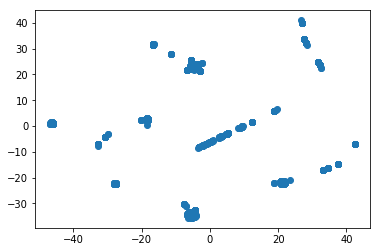

In [30]:
# Построим диаграмму рассеивания представления
from matplotlib import pyplot as plt

plt.scatter(tsne.embedding_[:, 0], tsne.embedding_[:, 1])

## Пора сажать деревья

In [24]:
# Разделим выборки на train и test
X_train, X_holdout, y_train, y_holdout = train_test_split(features_sparse, y, test_size=0.3, random_state=17)

In [25]:
X_train.shape, y_train.shape

((701818, 75531), (701818,))

In [26]:
%%time
tree = DecisionTreeClassifier(max_depth=5, random_state=17).fit(X_train, y_train)

CPU times: user 38.9 s, sys: 52.2 ms, total: 38.9 s
Wall time: 38.9 s


#### подберем параметры на кроссвалидации

In [27]:
#tree.feature_importances_

In [28]:
# tree params for grid search
tree_params = {'max_depth': list(range(21, 25))}            

tree_grid = GridSearchCV( DecisionTreeClassifier(random_state=17), tree_params, cv=5, verbose=True)

In [29]:
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 10.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [21, 22, 23, 24]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=True)

In [30]:
tree_grid.best_params_

{'max_depth': 24}

In [31]:
tree_grid.best_score_

0.996648703795001

сравним с таким методом получения оценки на кроссвалидации

In [18]:
from sklearn.model_selection import cross_val_score

In [19]:
np.mean(cross_val_score(tree, X_train, y_train, cv=5))

0.9904529881298408

можно еще вот так посчитать процент верных ответов

In [23]:
tree_holdout_pred = tree_grid.predict(X_holdout)

In [24]:
accuracy_score(y_holdout, tree_holdout_pred)

0.9909007528818682

нужен baseline. Посмотрим на долю людей в отложенной выборке

In [20]:
1 - np.mean(y)

0.9897291899055664

### Нарисуем дерево

In [23]:
from sklearn.tree import export_graphviz

In [24]:
export_graphviz(tree, out_file='tree11.dot', filled=True)

In [25]:
!ls *dot

tree10.dot  tree3.dot  tree5.dot  tree7.dot  tree.dot
tree11.dot  tree4.dot  tree6.dot  tree9.dot


In [26]:
!dot -Tpng tree11.dot -o tree11.png

<img src="tree11.png">

In [27]:
l = len(tree.feature_importances_)
np.sort(tree.feature_importances_)[l-1]

0.29040164620470793

In [28]:
pd.Series(tree.feature_importances_)[171]

0.0

In [29]:
# Найдем нашу операцию в словаре
for k in sorted(all_dict.keys()): 
    if all_dict[k] == 3106: print('1: {}'.format(k) , '->', all_dict[k])


1: https://ok.ru/profile/531055097552 -> 3106


# Добавим LR

In [22]:
from sklearn.linear_model import LogisticRegression

In [23]:
logit = LogisticRegression(C=0.1, n_jobs=-1, random_state=17)
logit.fit(X_train, y_train)

/home/greg/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
holdout_pred = logit.predict_proba(X_holdout)[:, 1]

In [25]:
holdout_pred.shape

(300779,)

In [26]:
roc_auc_score(y_holdout, holdout_pred)

0.99232424177757

### Построим кривую валидации для регуляризации

No handles with labels found to put in legend.


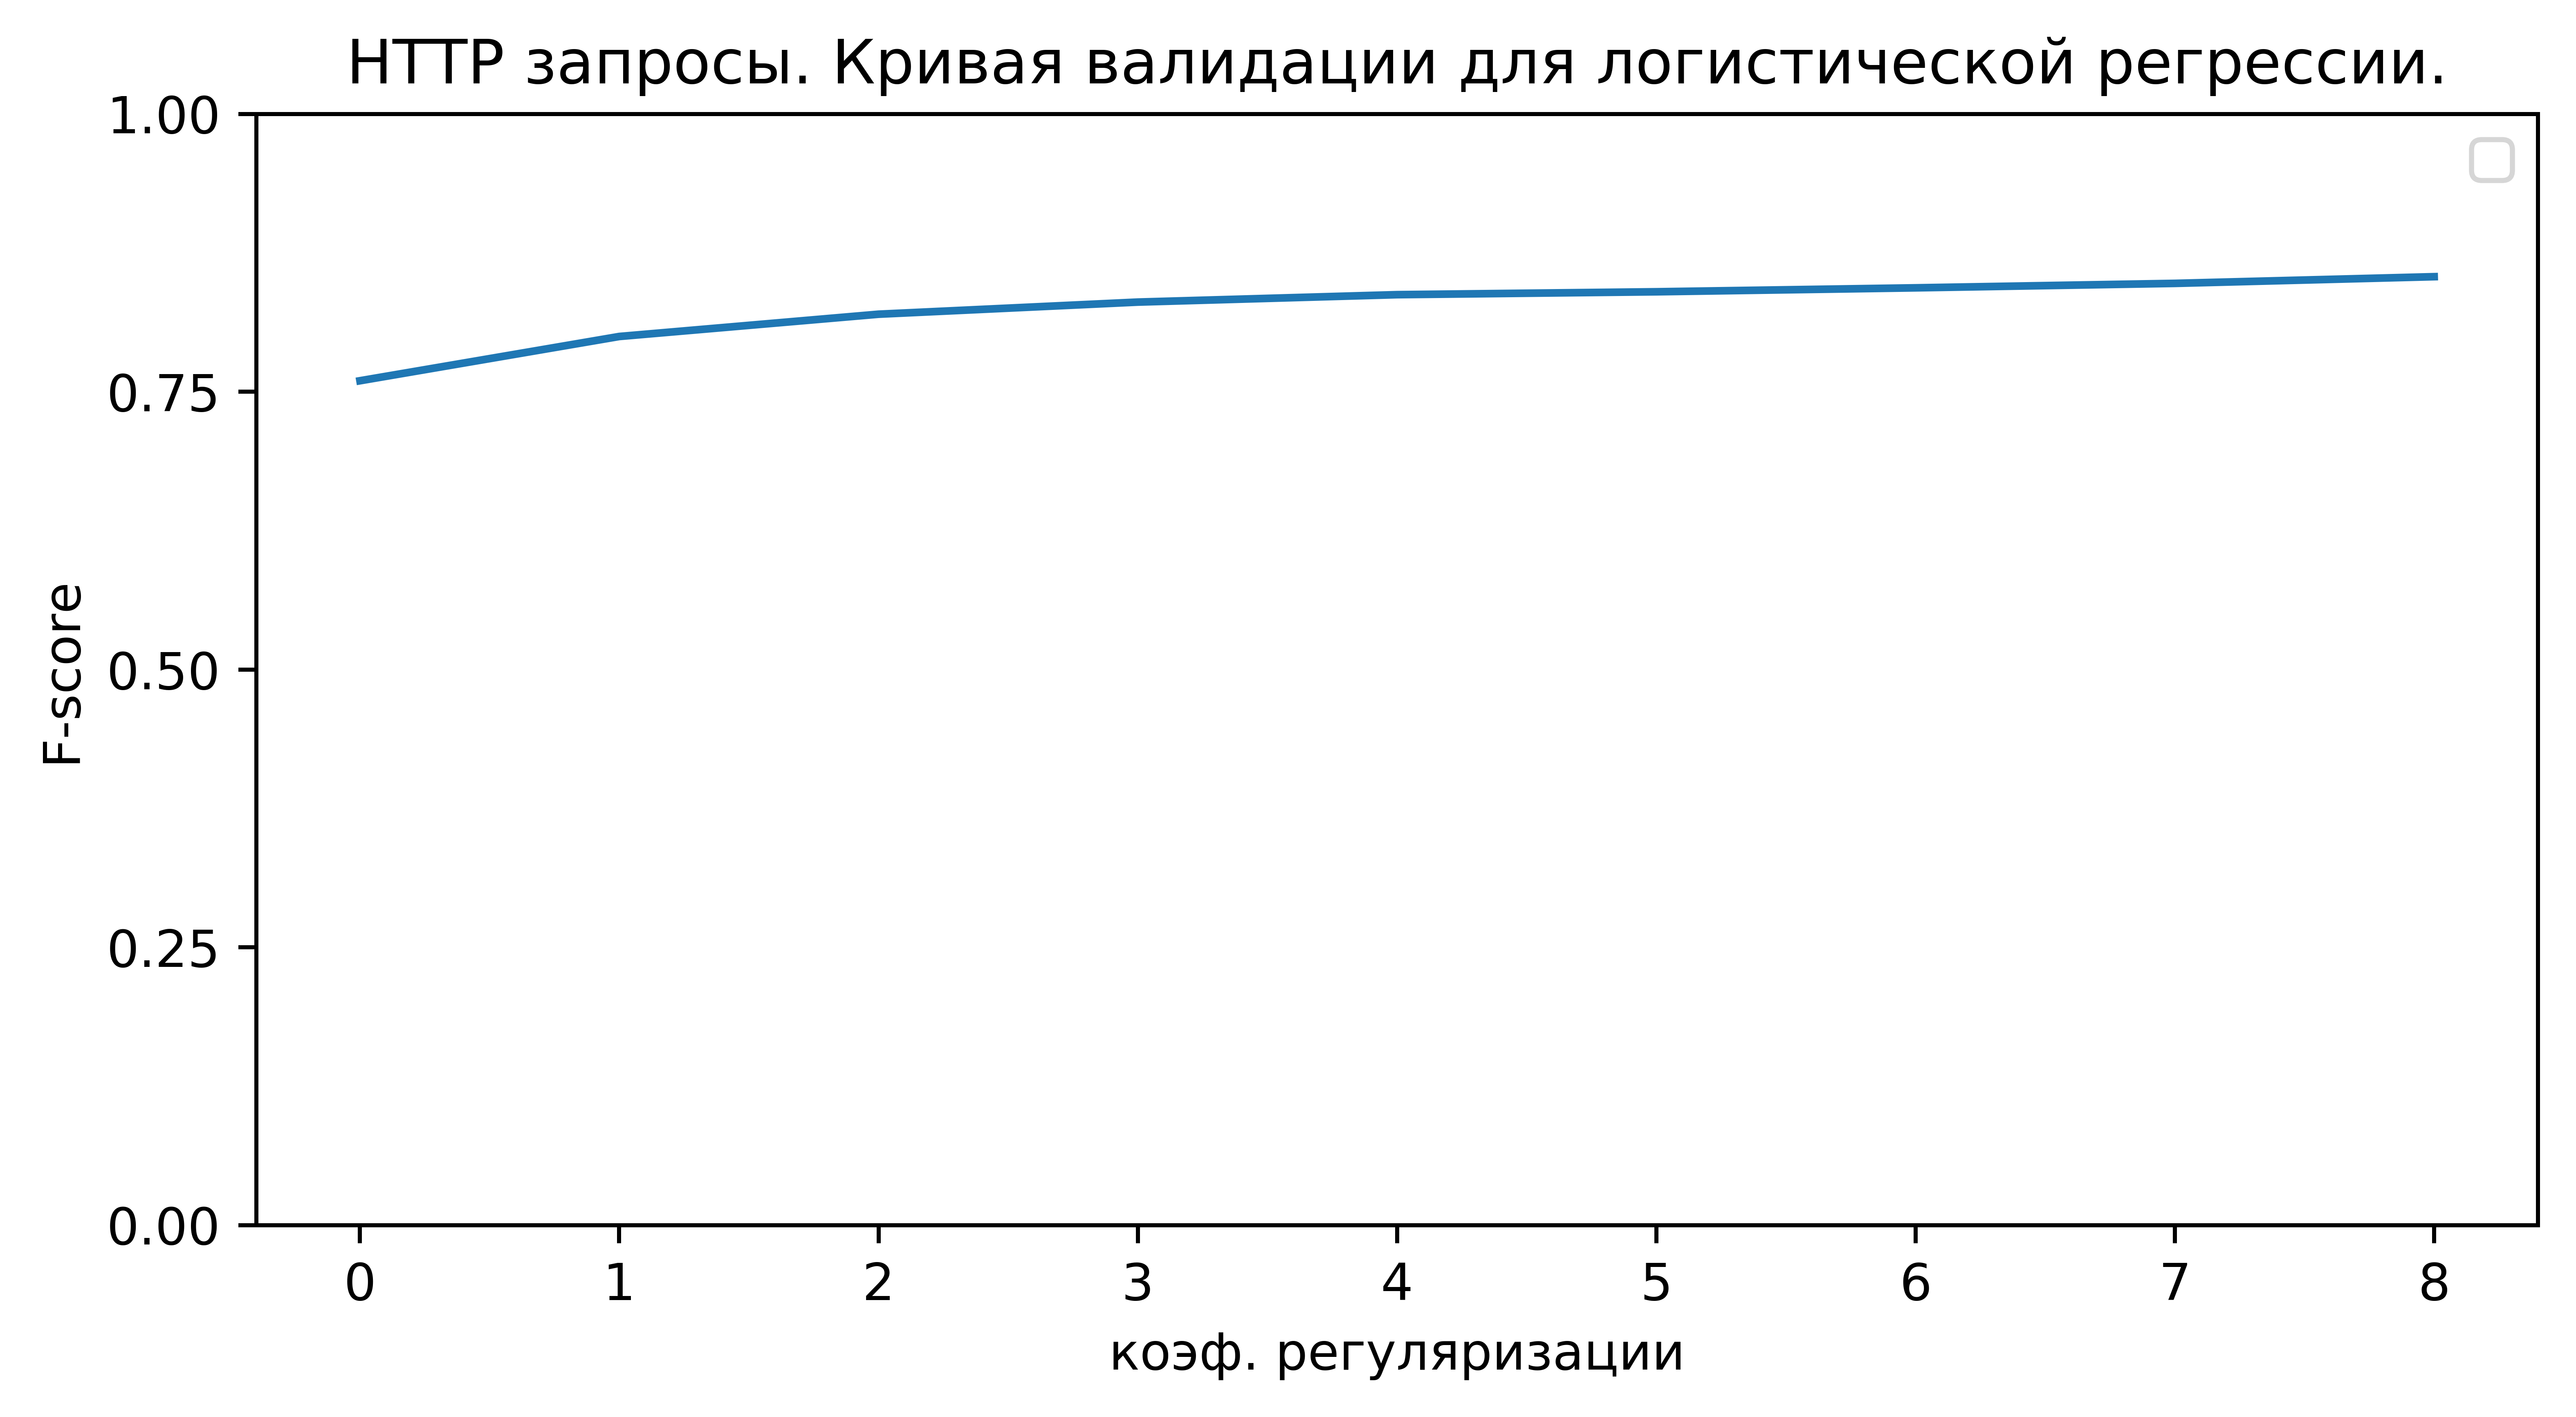

In [27]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
GRAPH_PATH = './graph'

reg_score = []
c = np.arange(0.1, 1, 0.1)

for i in c:
    logit=LogisticRegression(C=i)
    logit.fit(X_train, y_train)
    reg_score.append(f1_score(logit.predict(X_holdout), y_holdout))
                     
plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-score')
plt.xlabel('коэф. регуляризации')
plt.plot(reg_score)
plt.title('HTTP запросы. Кривая валидации для логистической регрессии.')
plt.savefig(GRAPH_PATH + 'logit_lear_curve.png', dpi=900)
plt.legend();

In [29]:
pred_holdout_series = pd.Series(holdout_pred).apply(lambda x: 1 if x>=0.3 else 0);

In [30]:
from sklearn import metrics

In [31]:
print(metrics.classification_report(y_holdout, pred_holdout_series))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    297621
          1       0.81      0.77      0.79      3158

avg / total       1.00      1.00      1.00    300779



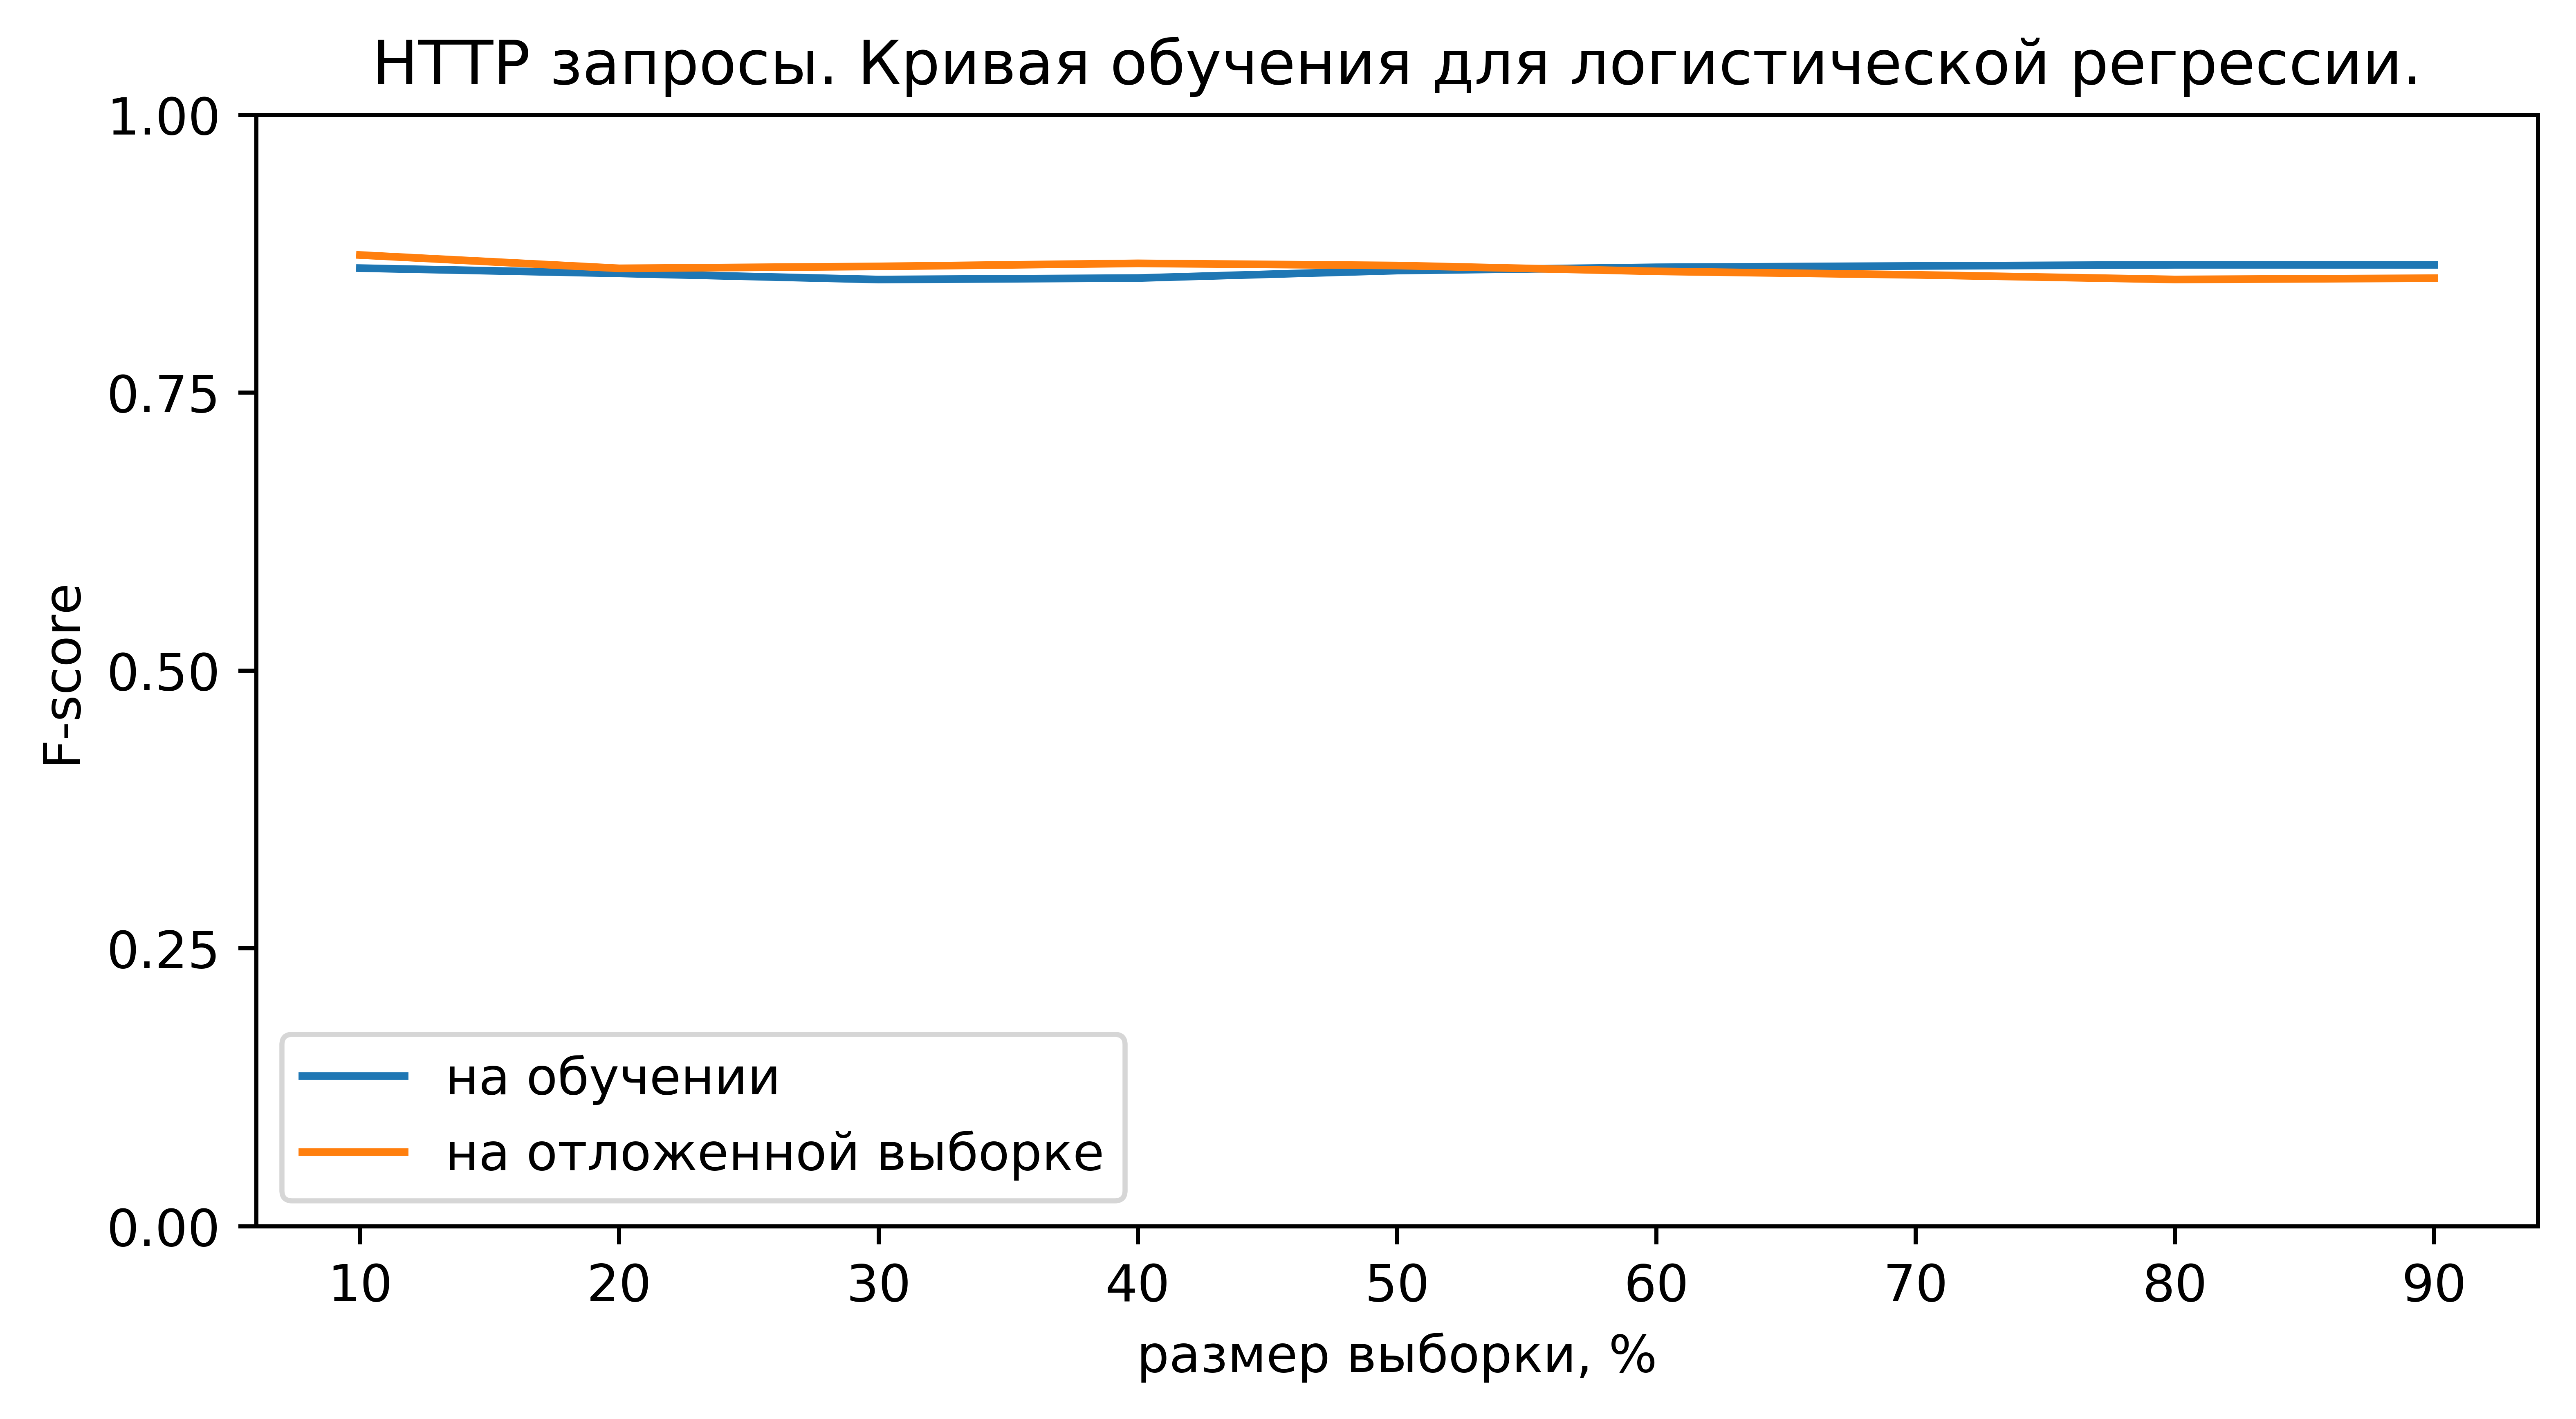

In [28]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
GRAPH_PATH = './graph'

cv_scores, holdout_scores = [], []
split = np.arange(0.1, 1, 0.1)

# для holdout
for i in split:
    split_idx = int(X_holdout.shape[0] * i)
    X_part, y_part = X_holdout[:split_idx], y_holdout[:split_idx]
    holdout_scores.append(f1_score(y_part, logit.predict(X_part)))
    
# для train
for i in split:
    split_idx = int(X_train.shape[0] * i)
    X_part, y_part = X_train[:split_idx], y_train[:split_idx]
    cv_scores.append(f1_score(logit.predict(X_part), y_part)) #todo: добавить cv

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-score')
plt.xlabel('размер выборки, %')
plt.plot(split * 100, cv_scores, label='на обучении')
plt.plot(split * 100, holdout_scores, label='на отложенной выборке')
plt.title('HTTP запросы. Кривая обучения для логистической регрессии.')
plt.savefig(GRAPH_PATH + 'logit_learn_curve.png', dpi=900)
plt.legend();

### Метрики, графики

In [30]:
from sklearn.metrics import classification_report

In [31]:
print(classification_report(tree.predict(X_holdout), y_holdout, target_names=['user', 'bot']))

             precision    recall  f1-score   support

       user       1.00      0.99      1.00      8974
        bot       0.38      0.74      0.50        50

avg / total       1.00      0.99      0.99      9024



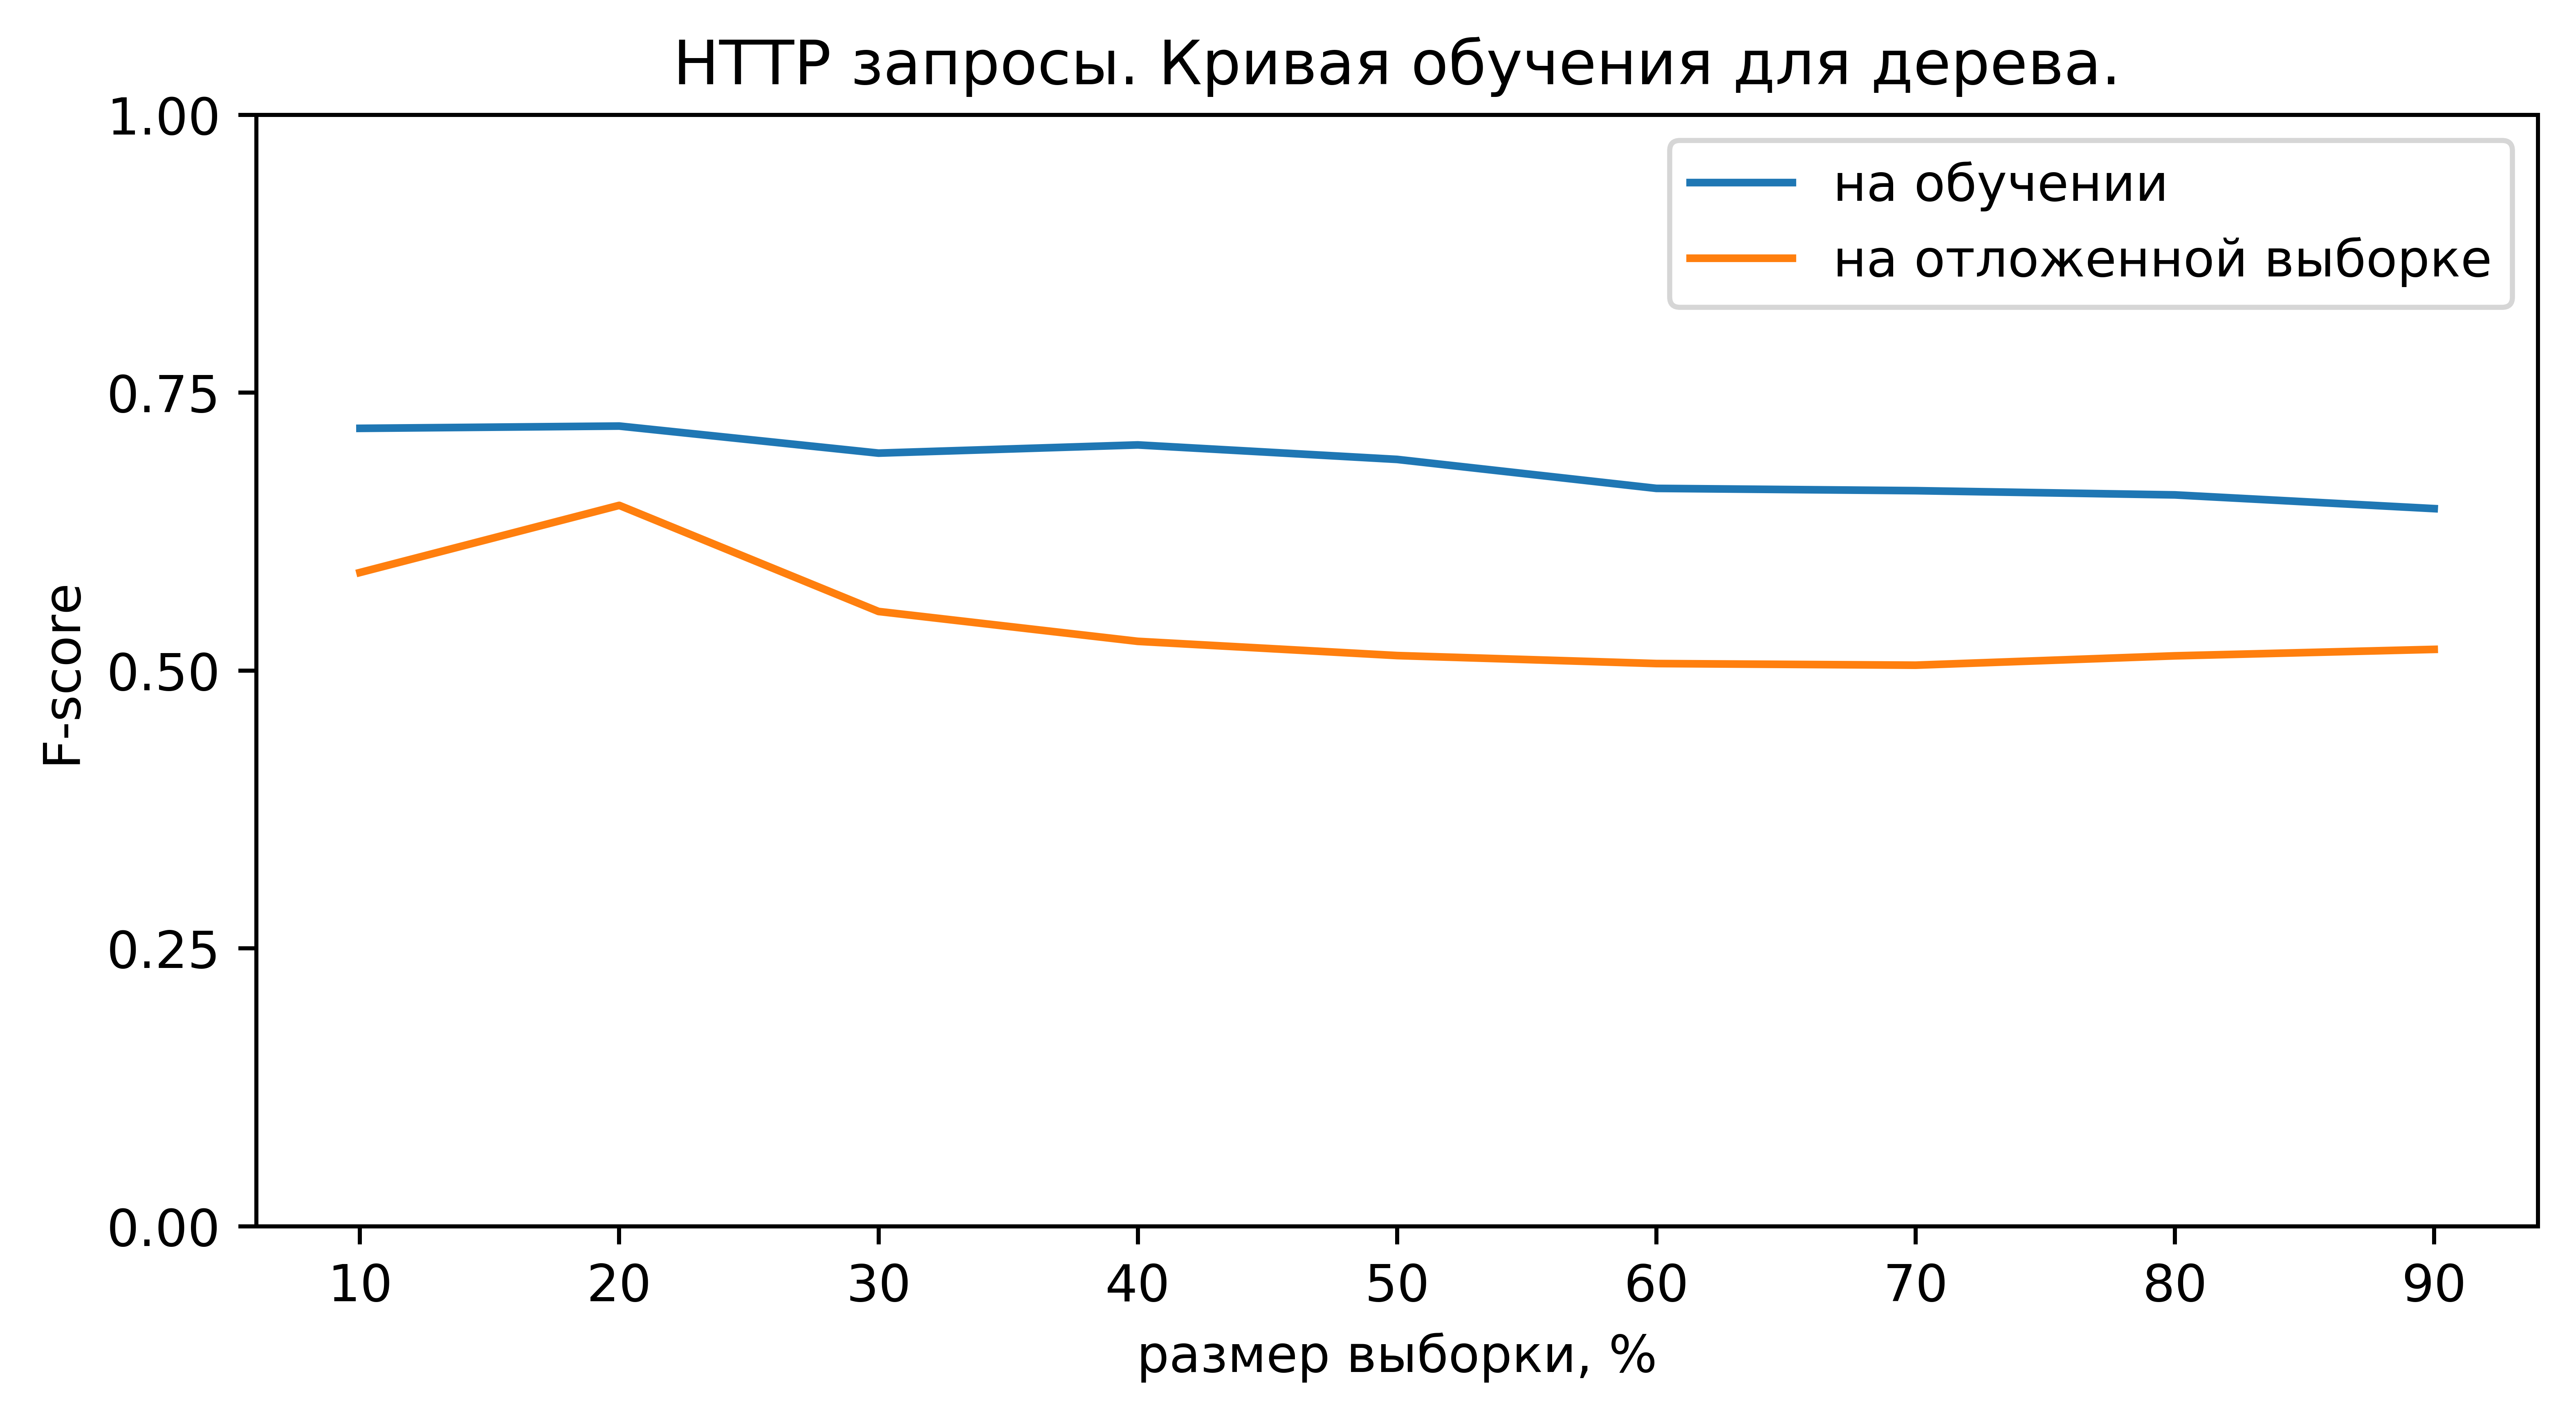

In [51]:
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
GRAPH_PATH = './graph'

cv_scores, holdout_scores = [], []
split = np.arange(0.1, 1, 0.1)

# для holdout
for i in split:
    split_idx = int(X_holdout.shape[0] * i)
    X_part, y_part = X_holdout[:split_idx], y_holdout[:split_idx]
    holdout_scores.append(f1_score(y_part, tree.predict(X_part)))
    
# для train
for i in split:
    split_idx = int(X_train.shape[0] * i)
    X_part, y_part = X_train[:split_idx], y_train[:split_idx]
    cv_scores.append(f1_score(tree.predict(X_part), y_part)) #todo: добавить cv

plt.figure(figsize=(8,4), dpi=900)
plt.ylim(0,1)
plt.yticks(np.linspace(0,1,5,endpoint=True))
plt.ylabel('F-score')
plt.xlabel('размер выборки, %')
plt.plot(split * 100, cv_scores, label='на обучении')
plt.plot(split * 100, holdout_scores, label='на отложенной выборке')
plt.title('HTTP запросы. Кривая обучения для дерева.')
plt.savefig(GRAPH_PATH + 'logins_svm_gcd_holdout.png', dpi=900)
plt.legend();

In [43]:
cross_val_score?